Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

kera.preprocessing to load the train_ds and then apply augmentation

### Importing all the important libraries

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

SystemError: ignored

In [7]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.keras.preprocessing.image import ImageDataGenerator

print(tf.__version__)


2.5.0


In [3]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset

data_dir_train = pathlib.Path("/content/drive/MyDrive/CancerData/Sarbdata/Skin cancer Image/Train")
data_dir_test = pathlib.Path('/content/drive/MyDrive/CancerData/Sarbdata/Skin cancer Image/Test')


In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2238
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6738 files belonging to 9 classes.
Using 5391 files for training.


In [ ]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 9 classes.
Using 23 files for validation.


Use 80% of the images for training, and 20% for validation.

In [ ]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


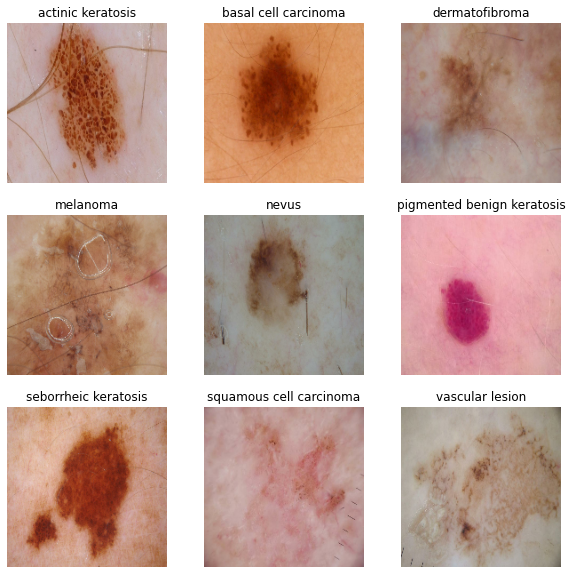

In [ ]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize = (10,10))
for images, labels in train_ds.take(2):
  for i in range(9):
    ax = plt.subplot(3,3, i+1)
    plt.imshow(images[i].numpy().astype("int64"))
    plt.title(class_names[i])
    plt.axis("off")

In [ ]:
train_ds

<BatchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.int32)>

In [ ]:
print(train_ds.take(0))
print(train_ds.take(1))
print(train_ds.take(2))

<TakeDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.int32)>
<TakeDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.int32)>
<TakeDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.int32)>


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

Note: the rescaling layer below standardizes pixel values to [0,1]. If instead we want [-1,1], we have to write Rescaling(1./127.5, offset=-1).

In [ ]:
### Your code goes here

image_size = 180

resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(image_size, image_size),
  layers.experimental.preprocessing.Rescaling(1./255)
  #layers.experimental.preprocessing.Rescaling(1./127.5, offset=-1)
])

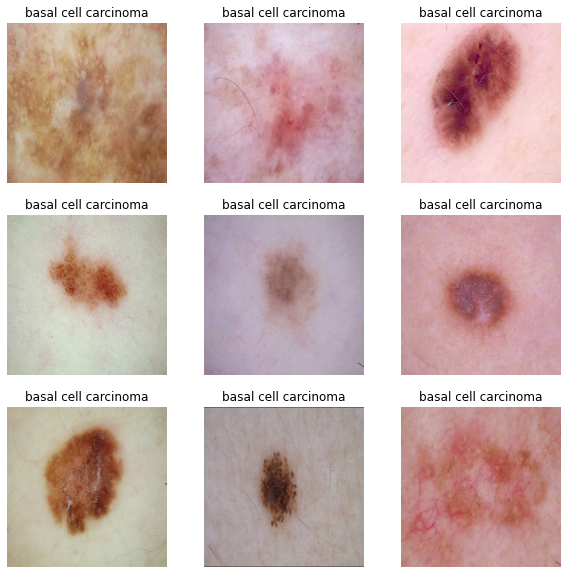

In [ ]:
train_ds.take(1)
plt.figure(figsize = (10,10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3,3, i+1)
    
    plt.imshow(resize_and_rescale(images[i].numpy().astype("int64")))
    plt.title(class_names[1])
    plt.axis("off")

In [ ]:
model = tf.keras.Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(len(class_names))
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 


https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/data_augmentation.ipynb#scrollTo=jMM3b85e3yhd

In [ ]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])



### Train the model with epochs = 5

In [ ]:
epochs=5
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/5
56/56 [==============================] - 42s 229ms/step - loss: 34.5477 - accuracy: 0.2338 - val_loss: 2.2141 - val_accuracy: 0.1304
Epoch 2/5
56/56 [==============================] - 2s 36ms/step - loss: 1.9456 - accuracy: 0.3008 - val_loss: 2.4325 - val_accuracy: 0.1304
Epoch 3/5
56/56 [==============================] - 2s 35ms/step - loss: 1.7769 - accuracy: 0.3772 - val_loss: 2.5518 - val_accuracy: 0.0870
Epoch 4/5
56/56 [==============================] - 2s 36ms/step - loss: 1.7158 - accuracy: 0.3717 - val_loss: 2.5917 - val_accuracy: 0.2174
Epoch 5/5
56/56 [==============================] - 2s 38ms/step - loss: 1.5243 - accuracy: 0.4581 - val_loss: 2.4998 - val_accuracy: 0.1304


In [ ]:
loss, acc = model.evaluate(val_ds)
print("Accuracy", acc)

1/1 [==============================] - 0s 28ms/step - loss: 2.4998 - accuracy: 0.1304
Accuracy 0.1304347813129425


In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 30976)            

### Train the model

In [ ]:
## Calling `save('my_model.h5')` creates a h5 file `my_model.h5`.
model.save("/content/drive/MyDrive/CancerData/my_h5_model.h5")


In [ ]:
# It can be used to reconstruct the model identically.
load_model = keras.models.load_model("/content/drive/MyDrive/CancerData/my_h5_model.h5")



In [ ]:
load_model.fit("/content/drive/MyDrive/CancerData/ISIC_0026163.jpg", test_target)

NameError: ignored

In [ ]:
# The reconstructed model is already compiled and has retained the optimizer
# state, so training can resume:
reconstructed_model.fit(test_input, test_target)

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 [==============================] - 3s 18ms/step - loss: 0.8600 - accuracy: 0.6977 - val_loss: 4.4019 - val_accuracy: 0.3043
Epoch 2/20
169/169 [==============================] - 3s 18ms/step - loss: 0.7435 - accuracy: 0.7368 - val_loss: 6.4947 - val_accuracy: 0.2174
Epoch 3/20
169/169 [==============================] - 3s 18ms/step - loss: 0.5936 - accuracy: 0.7930 - val_loss: 5.7611 - val_accuracy: 0.2174
Epoch 4/20
169/169 [==============================] - 3s 18ms/step - loss: 0.4733 - accuracy: 0.8372 - val_loss: 7.0641 - val_accuracy: 0.2609
Epoch 5/20
169/169 [==============================] - 3s 18ms/step - loss: 0.4583 - accuracy: 0.8470 - val_loss: 6.9839 - val_accuracy: 0.1304
Epoch 6/20
169/169 [==============================] - 3s 18ms/step - loss: 0.4791 - accuracy: 0.8477 - val_loss: 11.8690 - val_accuracy: 0.3043
Epoch 7/20
169/169 [==============================] - 3s 18ms/step - loss: 0.4176 - accuracy: 0.8609 - val_loss: 7.0434 - val_accuracy: 0.173

### Visualizing training results

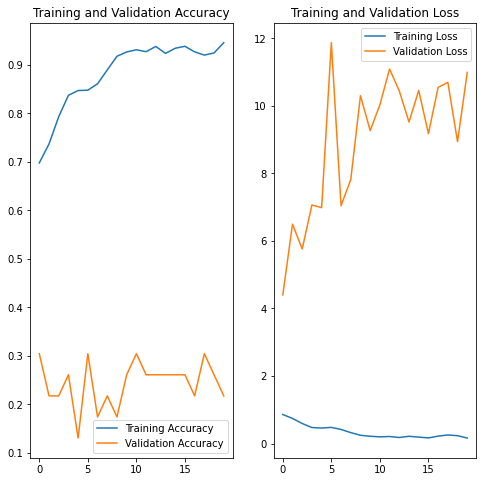

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit


### Write your findings here


  -  The result is showing drastic deep in validation accuracy. Which is the ***evidence of oevrfit.***

In [ ]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here

data_augmentation = tf.keras.Sequential([
  #layers.experimental.preprocessing.RandomFlip("horizontal"),
  #layers.experimental.preprocessing.RandomRotation(0.2),
  layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width,3)),
                                                 
  layers.experimental.preprocessing.RandomRotation(0.2),
  layers.experimental.preprocessing.RandomZoom(0.1)
  
])

#### Visualize few augmented examples how do they look like by applying data augmentation to the same image several times:
I will use data augmentation to train the model.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


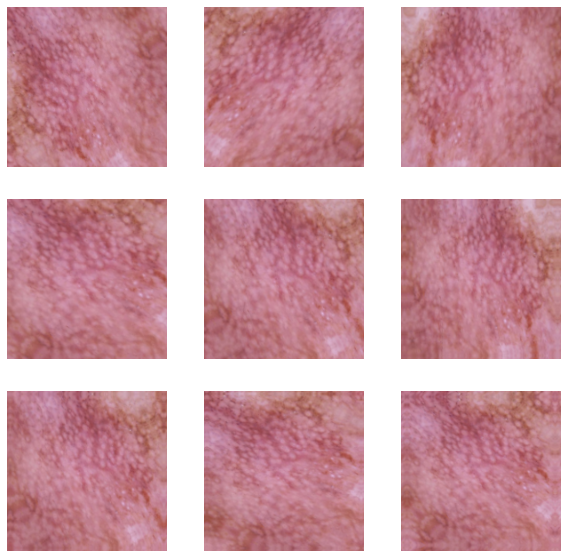

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(4):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
image, label = next(iter(train_ds))

In [ ]:
# Add the image to a batch
image = tf.expand_dims(image, 0)

In [ ]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

### Todo:
### Create the model, compile and train the model


In [ ]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(len(class_names))
])



### Compiling the model

In [ ]:
## Your code goes here

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [ ]:
## Your code goes here, note: train your model for 20 epochs

epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 [==============================] - 5s 22ms/step - loss: 1.9981 - accuracy: 0.2187 - val_loss: 2.6544 - val_accuracy: 0.1739
Epoch 2/20
169/169 [==============================] - 4s 21ms/step - loss: 1.6322 - accuracy: 0.3624 - val_loss: 2.6633 - val_accuracy: 0.1739
Epoch 3/20
169/169 [==============================] - 4s 21ms/step - loss: 1.5128 - accuracy: 0.4125 - val_loss: 2.7020 - val_accuracy: 0.2174
Epoch 4/20
169/169 [==============================] - 4s 21ms/step - loss: 1.4029 - accuracy: 0.4538 - val_loss: 2.1497 - val_accuracy: 0.3043
Epoch 5/20
169/169 [==============================] - 4s 21ms/step - loss: 1.3797 - accuracy: 0.4620 - val_loss: 2.1544 - val_accuracy: 0.3913
Epoch 6/20
169/169 [==============================] - 4s 21ms/step - loss: 1.3100 - accuracy: 0.4883 - val_loss: 2.1291 - val_accuracy: 0.3478
Epoch 7/20
169/169 [==============================] - 4s 21ms/step - loss: 1.2546 - accuracy: 0.5098 - val_loss: 1.8398 - val_accuracy: 0.3913

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

### Visualizing the results

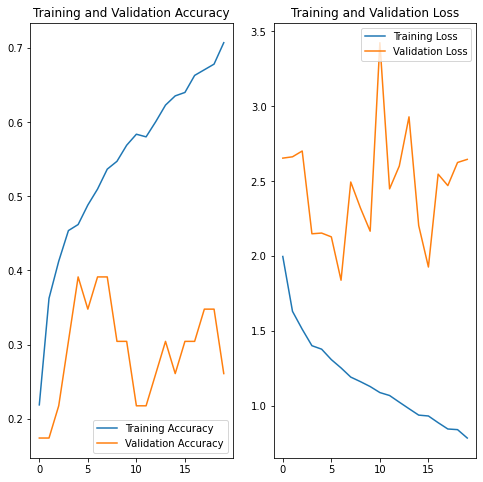

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### Ans - Yes I can see overfit is still there..analyzing further

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [ ]:
## Your code goes here.
image_class = {}
for i in class_names:
  class_image_count_train = len(list(data_dir_train.glob(i+'*/*.jpg')))
  #print(class_image_count_train)
  image_class[i] = class_image_count_train
#print(image_class)

sort_classes = sorted(image_class.items(), key=lambda x: x[1], reverse=True)
print("Here is the sorted image count under each class\n")
for i in sort_classes:
	print(i[0], i[1])



Here is the sorted image count under each class

pigmented benign keratosis 462
melanoma 438
basal cell carcinoma 376
nevus 357
squamous cell carcinoma 181
vascular lesion 138
actinic keratosis 114
dermatofibroma 95
seborrheic keratosis 77


#### **Todo:** Write your findings here: 

#### - Which class has the least number of samples?

> **Ans- "seborrheic keratosis" , Sample data = 77**


#### - Which classes dominate the data in terms proportionate number of samples?

>**"pigmented benign keratosis" dominate the data  with samples= 462**


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
print(data_dir_train.absolute())

/content/drive/MyDrive/CancerData/Sarbdata/Skin cancer Image/Train


In [ ]:
pip install Augmentor

In [ ]:
import Augmentor
import os
path_to_training_dataset = data_dir_train.absolute()

print(type(str(path_to_training_dataset)))

for i in class_names: 
    print(str(path_to_training_dataset) + i)
    p = Augmentor.Pipeline(str(path_to_training_dataset) + "/" + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

<class 'str'>
/content/drive/MyDrive/CancerData/Sarbdata/Skin cancer Image/Trainactinic keratosis


Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/CancerData/Sarbdata/Skin cancer Image/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FF8781AB150>: 100%|██████████| 500/500 [00:20<00:00, 24.14 Samples/s]


/content/drive/MyDrive/CancerData/Sarbdata/Skin cancer Image/Trainbasal cell carcinoma


Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FF8C2D5A350>:   0%|          | 1/500 [00:00<01:09,  7.15 Samples/s]

Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/CancerData/Sarbdata/Skin cancer Image/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF8C2D51B10>: 100%|██████████| 500/500 [00:20<00:00, 24.35 Samples/s]


/content/drive/MyDrive/CancerData/Sarbdata/Skin cancer Image/Traindermatofibroma


Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF8B02FEF90>:   0%|          | 1/500 [00:00<01:38,  5.07 Samples/s]

Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/CancerData/Sarbdata/Skin cancer Image/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF8B02FEE50>: 100%|██████████| 500/500 [00:21<00:00, 23.78 Samples/s]


/content/drive/MyDrive/CancerData/Sarbdata/Skin cancer Image/Trainmelanoma


Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/CancerData/Sarbdata/Skin cancer Image/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=2048x1536 at 0x7FF8C30A4910>: 100%|██████████| 500/500 [01:41<00:00,  4.95 Samples/s]


/content/drive/MyDrive/CancerData/Sarbdata/Skin cancer Image/Trainnevus


Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/CancerData/Sarbdata/Skin cancer Image/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=962x674 at 0x7FF8B0093410>: 100%|██████████| 500/500 [01:19<00:00,  6.32 Samples/s]


/content/drive/MyDrive/CancerData/Sarbdata/Skin cancer Image/Trainpigmented benign keratosis


Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/CancerData/Sarbdata/Skin cancer Image/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF8C2FCA690>: 100%|██████████| 500/500 [00:20<00:00, 24.18 Samples/s]


/content/drive/MyDrive/CancerData/Sarbdata/Skin cancer Image/Trainseborrheic keratosis


Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/CancerData/Sarbdata/Skin cancer Image/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FF8B02F8250>: 100%|██████████| 500/500 [00:43<00:00, 11.41 Samples/s]


/content/drive/MyDrive/CancerData/Sarbdata/Skin cancer Image/Trainsquamous cell carcinoma


Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FF8781E3BD0>:   0%|          | 2/500 [00:00<00:25, 19.17 Samples/s]

Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/CancerData/Sarbdata/Skin cancer Image/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF917134210>: 100%|██████████| 500/500 [00:20<00:00, 24.85 Samples/s]


/content/drive/MyDrive/CancerData/Sarbdata/Skin cancer Image/Trainvascular lesion


Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 138 image(s) found.
Output directory set to /content/drive/MyDrive/CancerData/Sarbdata/Skin cancer Image/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FF8781E2D90>: 100%|██████████| 500/500 [00:21<00:00, 23.60 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
#path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list = list(data_dir_train.glob('*/output/*.jpg'))
path_list

[PosixPath('/content/drive/MyDrive/CancerData/Sarbdata/Skin cancer Image/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0027976.jpg_8979668b-5b0f-46dd-94c2-55b191e9b49f.jpg'),
 PosixPath('/content/drive/MyDrive/CancerData/Sarbdata/Skin cancer Image/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0028303.jpg_b5628b24-07a9-4d67-b8ec-0cf0e887d255.jpg'),
 PosixPath('/content/drive/MyDrive/CancerData/Sarbdata/Skin cancer Image/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0024833.jpg_6417f718-40b6-4dda-9d3a-6aefae87901a.jpg'),
 PosixPath('/content/drive/MyDrive/CancerData/Sarbdata/Skin cancer Image/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0027920.jpg_6f0d3510-b26a-4089-b62d-c9384e68756d.jpg'),
 PosixPath('/content/drive/MyDrive/CancerData/Sarbdata/Skin cancer Image/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0025601.jpg_1f3ca083-c509-475f-864b-6168ff9a777b.jpg'),
 PosixPath

In [ ]:
#import glob
#lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in data_dir_train.glob('*/output/*.jpg')]
#path_list_new = list(data_dir_train.glob('*/output/*.jpg'))
#print(lesion_list_new)




So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [ ]:


#data_dir_train= "Train data + augmented data"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6738 files belonging to 9 classes.
Using 5391 files for training.


#### **Todo:** Create a validation dataset

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6738 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [ ]:
## your code goes here
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(len(class_names))
])


#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [ ]:
## your code goes here

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [ ]:
epochs = 50
## Your code goes here, use 50 epochs.
# your model fit code


history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
169/169 [==============================] - 73s 246ms/step - loss: 1.8916 - accuracy: 0.2680 - val_loss: 1.7334 - val_accuracy: 0.3482
Epoch 2/50
169/169 [==============================] - 38s 221ms/step - loss: 1.5608 - accuracy: 0.4042 - val_loss: 1.4832 - val_accuracy: 0.4321
Epoch 3/50
169/169 [==============================] - 39s 224ms/step - loss: 1.4568 - accuracy: 0.4424 - val_loss: 1.3763 - val_accuracy: 0.4662
Epoch 4/50
169/169 [==============================] - 38s 219ms/step - loss: 1.3984 - accuracy: 0.4641 - val_loss: 1.4260 - val_accuracy: 0.4469
Epoch 5/50
169/169 [==============================] - 39s 226ms/step - loss: 1.3424 - accuracy: 0.4854 - val_loss: 1.2962 - val_accuracy: 0.4788
Epoch 6/50
169/169 [==============================] - 37s 214ms/step - loss: 1.3291 - accuracy: 0.4942 - val_loss: 1.5264 - val_accuracy: 0.4202
Epoch 7/50
169/169 [==============================] - 38s 221ms/step - loss: 1.2701 - accuracy: 0.5173 - val_loss: 1.5757 - val_ac

## DEPLOY MODEL -

### Save the model as h5 model to deploy, reload the  h5 model and predict unknown /test images using h5 model.

### This model can be deployed using any GUI like tkinter, webpage or cloud endpoint.

In [ ]:

#model.save('/content/drive/MyDrive/CancerModel')
model.save("/content/drive/MyDrive/CancerData/mymodel.h5")

## Reload the Model

In [5]:
# It can be used to reconstruct the model identically.
reconstructed_model = keras.models.load_model("/content/drive/MyDrive/CancerData/mymodel.h5")


In [ ]:
reconstructed_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)       

### Model Deploy- Extract the test image 

In [ ]:

# Let's not check this use the new code:
#predictions = reconstructed_model.predict(testing_ds)
#score= tf.nn.softmax(predictions[0])

#print(class_names[np.argmax(score)], 100* np.max(score))

squamous cell carcinoma 49.2466539144516


In [17]:
#Model Deploy- Extract the test image and predict by using the saved h5 model

data_dir_test1 = pathlib.Path('/content/drive/MyDrive/CancerData/Test1')
list(data_dir_test1.glob('*.jpg'))

[PosixPath('/content/drive/MyDrive/CancerData/Test1/ISIC_0010512.jpg'),
 PosixPath('/content/drive/MyDrive/CancerData/Test1/ISIC_0025427.jpg')]

### Set up class names

In [13]:
class_names = ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']

### Pre process the test image, and predict the class of test image by using the saved h5 model

In [16]:
#Model Deploy-  #change the array number of list(data_dir_test1.glob('*.jpg'))[1] if we have multiple images

test_img = keras.preprocessing.image.load_img(str(list(data_dir_test1.glob('*.jpg'))[1]), target_size=(180,180))
img_array = keras.preprocessing.image.img_to_array(test_img)
img_array = tf.expand_dims(img_array,0)

#Predict the test image
predictions = reconstructed_model.predict(img_array)

#Get the probability score from softmax
score= tf.nn.softmax(predictions[0])

print(class_names[np.argmax(score)], 100* np.max(score))


actinic keratosis 92.58255362510681


In [ ]:
reconstructed_model.predict(val_ds)

array([[-2.13404799e+00,  4.53485394e+00, -1.67891178e+01,
        -1.39443719e+00, -1.72918886e-01,  8.43267918e+00,
        -1.06286335e+01,  3.40038753e+00, -1.08920517e+01],
       [-2.91295099e+00,  9.82092667e+00,  8.01000214e+00,
         5.96919012e+00,  6.54768658e+00,  6.91931963e+00,
        -1.51091471e+01,  3.53062654e+00, -1.42912111e+01],
       [-8.10910797e+00, -8.78424454e+00, -6.08488083e+00,
         9.71706486e+00,  6.23143864e+00, -6.06773615e+00,
         8.47609138e+00, -1.48316803e+01, -1.19653921e+01],
       [ 5.91686344e+00,  9.61846352e+00, -1.55881004e+01,
         4.38036156e+00,  1.53046608e+00,  8.07222366e+00,
        -4.54372168e+00,  2.20673466e+00, -1.34012756e+01],
       [-3.23258424e+00,  7.31003046e-01, -3.25317359e+00,
        -6.61231637e-01,  8.33198845e-01,  1.85748863e+00,
        -3.46609664e+00, -4.35853511e-01, -1.28885765e+01],
       [-2.41452050e+00,  5.55688238e+00, -5.88057089e+00,
        -4.10012245e-01, -1.58107662e+00, -6.497721

In [ ]:

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']

Found 1 files belonging to 1 classes.


In [ ]:
loss, acc = reconstructed_model.evaluate(val_ds)

1/1 [==============================] - 1s 911ms/step - loss: 5.1825 - accuracy: 0.1739


#### **Todo:**  Visualize the model results

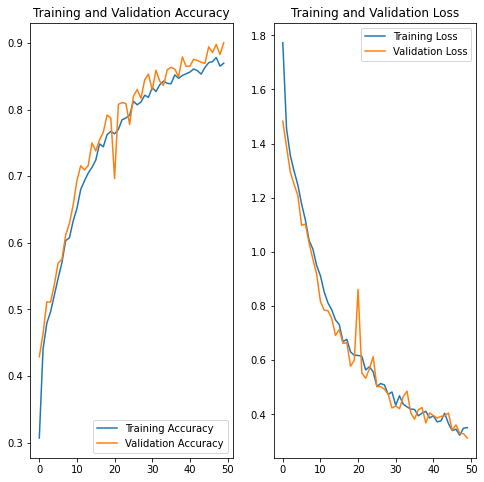

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?





*   ### The final Model is showing a good improvement in Validation **Accuracy ~ 78%** which shows that the overfitting problem has been resolved.


*   ### The class rebalance using Augmentor library has helped the Model to resolve imbalance problem

*   ### The accuracy result is showing 30 epoch can be selected as after 30 epoch that validation accuracy has been increased between ~ 75 to 79.




